# 测试：通过不同的多边形的边来进行耕作，并且记录其作业的面积占比

In [62]:
import geopandas as gpd
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit, CPP_Algorithm_Optimizers
from shapely import affinity
from skimage.measure import approximate_polygon
import warnings
import math

warnings.filterwarnings('ignore')

In [63]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# 这里要控制精度
all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.05)
# 对当前 all_land 添加一个 mean_slope 字段 [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land['mean_slope'] = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
land_angle = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land

,NAME,LAYER,周长,闭合面积,geometry,mean_slope
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.600 4397401.450, 440401.850 4...",3.37
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.950 4397335.400, 440484.500 4...",7.38
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.250 4397608.050, 440469.000 4...",6.07
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.050 4397795.250, 440451.850 4...",3.94
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.800 4397768.750, 440351.250 4...",6.53
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.750 4397785.800, 440309.100 4...",7.46
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.850 4397414.750, 440398.850 4...",7.62


split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4


<Axes: >

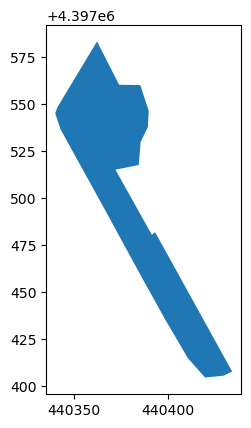

In [64]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
single_angle = land_angle[6]
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.05)
single_land.plot()

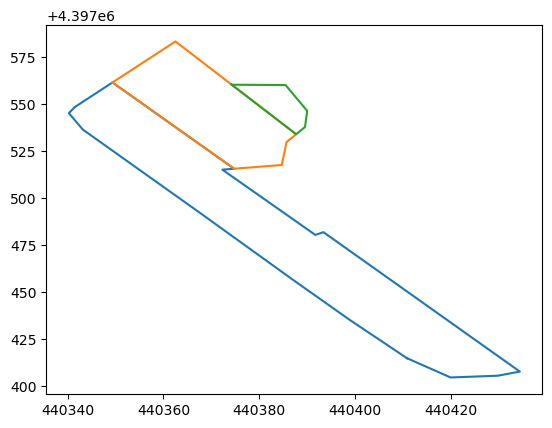

In [65]:
_, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)

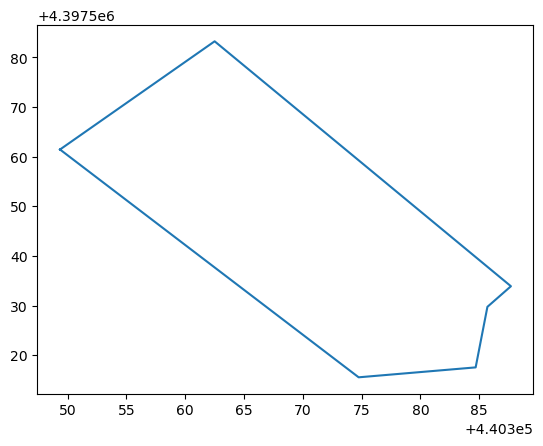

In [66]:
# 取出其中一个地块来测试耕作方向
single_polygon = split_polygon[1]
plt.plot(*single_polygon.exterior.xy)

### 现在需要记录地块上各个边界的角度，对于存在部分凹陷的地块，直接去其凸包

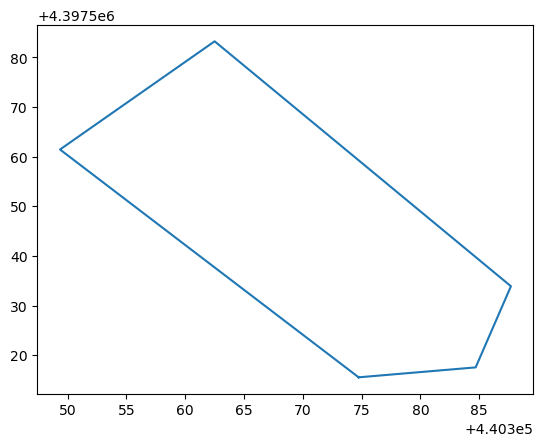

In [67]:
# 获取凸包
single_convex_hull = single_polygon.convex_hull
plt.plot(*single_convex_hull.exterior.xy)

In [68]:
edge_angles = []
# 计算各个边的角度
for i in range(len(single_convex_hull.exterior.coords) - 1):
    p1 = single_convex_hull.exterior.coords[i]
    p2 = single_convex_hull.exterior.coords[i + 1]
    line = LineString([p1, p2])
    angle = math.degrees(math.atan2(line.coords[1][1] - line.coords[0][1], line.coords[1][0] - line.coords[0][0]))
    edge_angles.append(angle)
print(edge_angles)

[118.95912890197019, 58.901157676788245, -62.93889386252676, -62.958577656941024, -100.39733352208876, -168.63470930214314]


-100.39733352208876


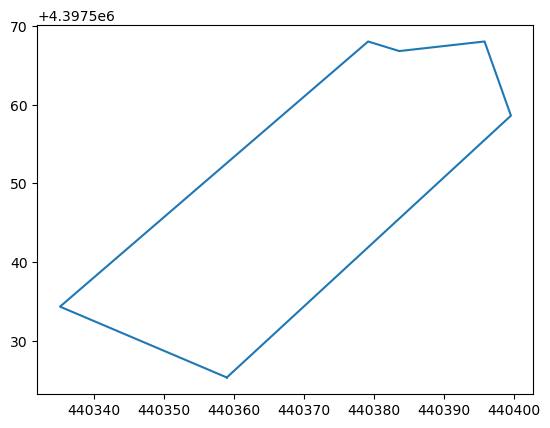

In [69]:
t_angle = edge_angles[4]
print(t_angle)
temp_poly = affinity.rotate(single_polygon, -t_angle, origin='centroid')
plt.plot(*temp_poly.exterior.xy)

In [70]:
corrected_swath_width = CPP_Planner_Kit.get_corrected_swath_width(1.45, single_angle)
path_headland_collection = []
# land_centroid = single_land.centroid[0]
for t_angle in edge_angles:
    # rotated_polygon_gpd = gpd.GeoDataFrame(geometry=[single_polygon], crs=all_land.crs)
    # t_path, t_headland = CPP_Algorithms.scanline_algorithm_with_headland_by_direction(
    #     land=rotated_polygon_gpd, step_size= corrected_swath_width, land_angle=t_angle,
    #     headland='left', head_land_width=6
    # )
    rotated_polygon = affinity.rotate(single_polygon, -t_angle, origin='centroid')
    rotated_polygon_regen = gpd.GeoDataFrame(geometry=[rotated_polygon], crs=all_land.crs)
    land_centroid = rotated_polygon_regen.centroid[0]
    # print(land_centroid.coords[0][0])
    t_path, t_headland = CPP_Algorithms.scanline_algorithm_single_with_headland(
        land=rotated_polygon_regen, step_size=corrected_swath_width, along_long_edge=False,
        headland='left', head_land_width=6, get_largest_headland=False
    )
    t_path = t_path.rotate(t_angle, origin=(land_centroid.coords[0][0], land_centroid.coords[0][1]))
    t_headland = t_headland.rotate(t_angle, origin=(land_centroid.coords[0][0], land_centroid.coords[0][1]))
    path_headland_collection.append([t_path, t_headland])
# path_headland_collection

6


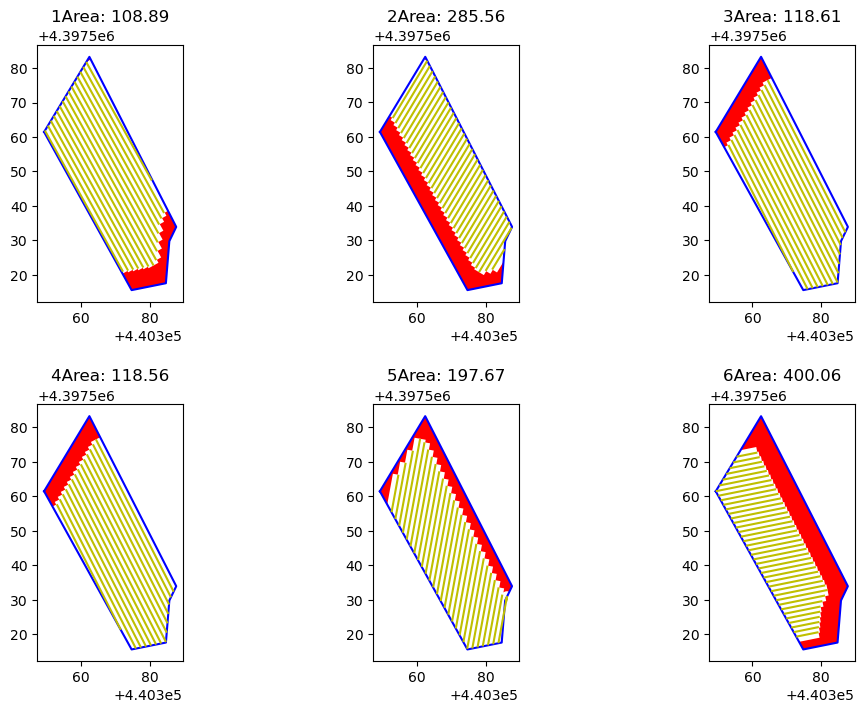

In [71]:
num_edge = len(path_headland_collection)
print(num_edge)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for i, ax in enumerate(axes.flatten()):
    if i < num_edge:
        t_path = path_headland_collection[i][0]
        t_headland = path_headland_collection[i][1]
        ax.plot(*single_polygon.exterior.xy, color='b')
        t_path.plot(ax=ax, color='y')
        t_headland.plot(ax=ax, color='r')
        # ax.text(0.5, 0.5, f'Area: {t_headland.area[0].round(2)}', transform=ax.transAxes, ha='left', va='bottom')
        ax.set_title(f"{i+1}Area: {t_headland.area[0].round(2)}")

<Axes: >

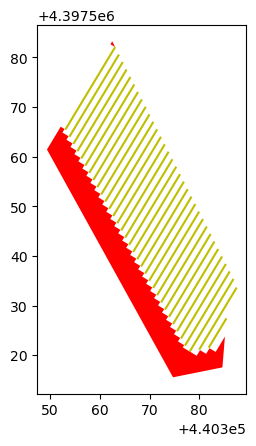

In [72]:
path1, headland1 = path_headland_collection[1]
_, ax = plt.subplots()
path1.plot(ax=ax, color='y')
headland1.plot(ax=ax, color='r')

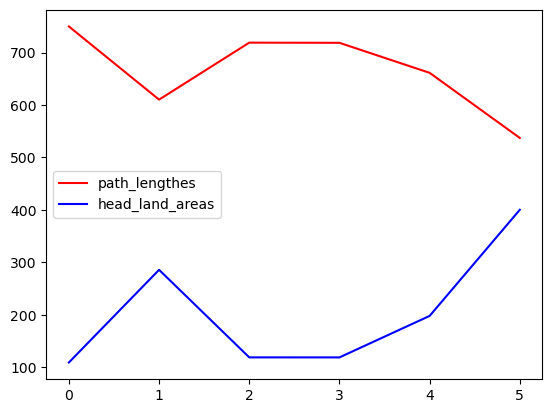

In [73]:
# 尝试计算 path_headland_collection[0][1] 中 所有linestring 的长度
path_lengthes = []
head_land_areas = []
for i in range(num_edge):
    temp_length = 0
    head_land_areas.append(path_headland_collection[i][1].area[0])
    for line in path_headland_collection[i][0].geometry:
        temp_length += line.length
    path_lengthes.append(temp_length)
_, ax = plt.subplots()
ax.plot(path_lengthes, color='r')
ax.plot(head_land_areas, color='b')
ax.legend(['path_lengthes', 'head_land_areas'])

#### 测试CPP中编写的代码

<Axes: >

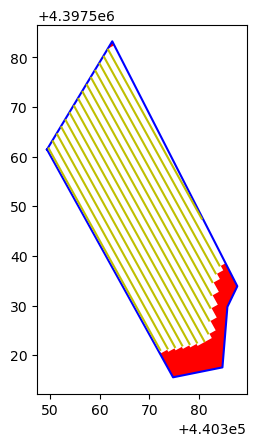

In [76]:
single_polygon_regen = gpd.GeoDataFrame(geometry=[single_polygon], crs=all_land.crs)
temp_path, temp_headland = CPP_Algorithm_Optimizers.gen_path_with_minimum_headland_area_by_edge(
    land=single_polygon_regen, step_size=corrected_swath_width, head_land_width=6,
    headland_mode='left', compare_mode='headland'
)
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, color='b')
temp_path.plot(ax=ax, color='y')
temp_headland.plot(ax=ax, color='r')

In [75]:
temp_headland.area

0    108.891079
dtype: float64